In [ ]:
import numpy as np
import scipy.stats as ss

from multiinstance.density_ratio_em import generateBags, DensityRatioEM


import matplotlib.pyplot as plt

from easydict import EasyDict

import tensorflow as tf

In [ ]:
class Mixture:
    def __init__(self, phi, pi):
        self.phi = phi
        self.pi = np.array(pi)
    def pdf(self,x):
        return np.array([np.dot(self.pi, [phi_i.pdf(xi) for phi_i in self.phi]) for xi in x])
    def rvs(self,size):
        n = np.round(self.pi * size).astype(int)
        x = np.zeros((0,1))
        for phi,ni in zip(self.phi, n):
            x = np.concatenate((x, phi.rvs(ni)[:,None]))
        return x,n

In [ ]:
k0P,k1P = ss.norm(loc=-5,scale=1), ss.norm(loc=7,scale=1)
k0N,k1N = ss.norm(loc=-4,scale=1),ss.norm(loc=5,scale=1)

In [ ]:
bags = generateBags(1, NPos=100, NUnlabeled=1000,
                    pos_means=[[k0P.mean()], [k1P.mean()]],
                    neg_means=[[k0N.mean()],[k1N.mean()]],
                    pos_covs=[k0P.var(), k1P.var()], 
                    neg_covs=[k0N.var(), k1N.var()],)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

In [ ]:
f1 = Mixture([k0P,k1P],bags[0].pi)

f0 = Mixture([k0N, k1N],bags[0].rho)

alpha = bags[0].alpha
posterior = lambda a,x,f0_,f1_: a / (a + (1 - a) * f0_.pdf(x)/f1_.pdf(x))

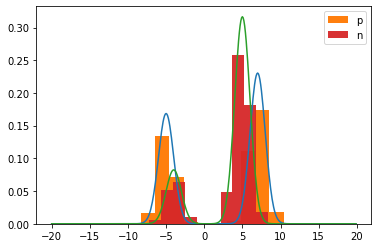

In [ ]:
rng = np.arange(-20,20,.1)
plt.plot(rng,f1.pdf(rng))
plt.hist(f1.rvs(10000)[0].ravel(),density=True,label="p")
plt.plot(rng,f0.pdf(rng))
_ = plt.hist(f0.rvs(10000)[0].ravel(),density=True,alpha=.95,label="n")
plt.legend()

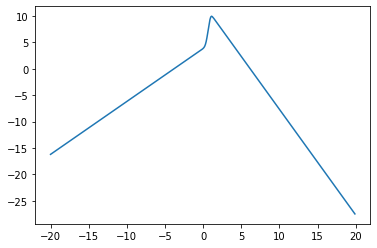

In [ ]:
 plt.plot(rng, np.log(f0.pdf(rng))- np.log(f1.pdf(rng)))

In [ ]:
net = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1000,input_shape=(1,),activation="relu"),
    tf.keras.layers.Dense(1000,activation="relu"),
    tf.keras.layers.Dense(1000,activation="relu"),
    tf.keras.layers.Dense(1),
])

net.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))

In [ ]:
x,y = np.concatenate((f0.rvs(1000)[0],
                      f1.rvs(1000)[0])), np.concatenate((np.ones(1000).astype(bool),
                                                      np.zeros(1000).astype(bool)))



In [ ]:
# x0 = f0.rvs(1000)[0]
# x1 = f1.rvs(1000)[0]
# beta = np.random.beta(2,2,size=1000)
# xMix = x0 * beta[:,None] + (1 - beta[:,None]) * x1
# x = np.concatenate((x,xMix))
# y = np.concatenate((y,beta))

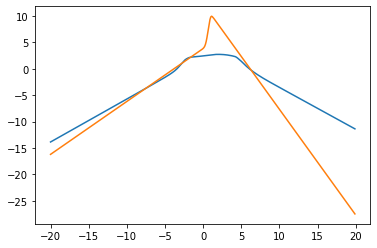

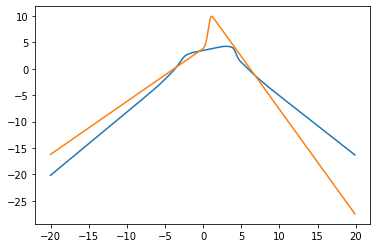

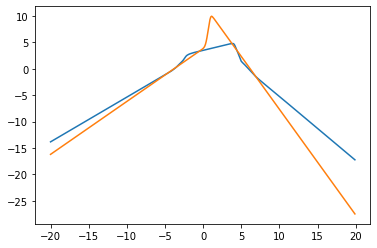

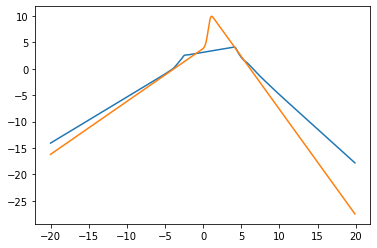

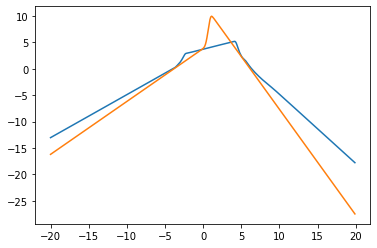

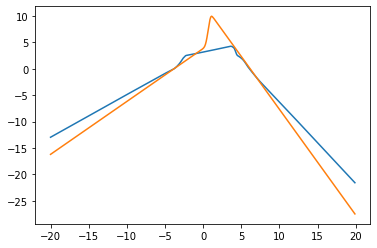

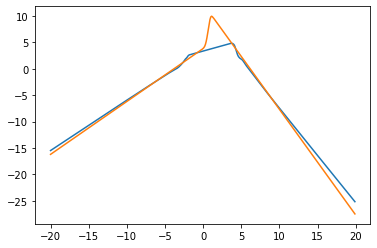

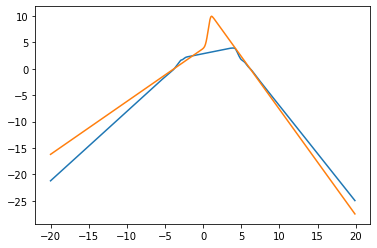

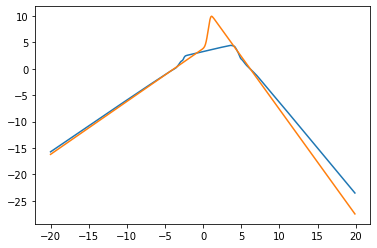

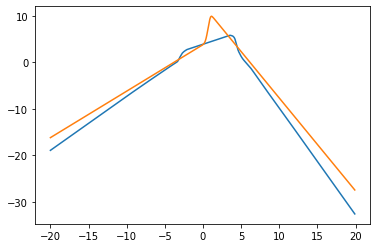

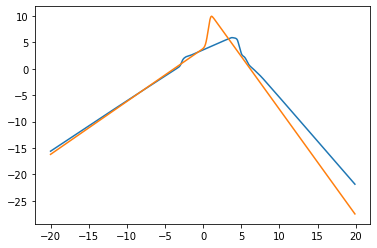

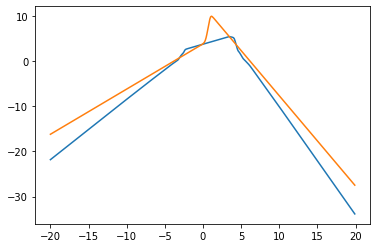

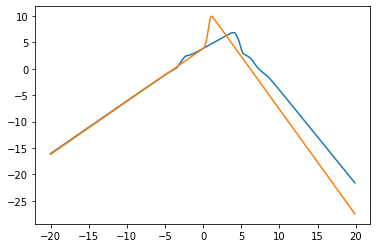

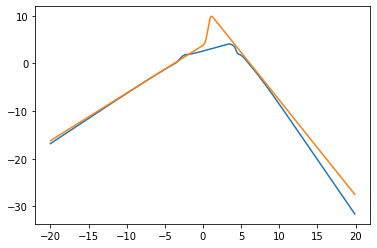

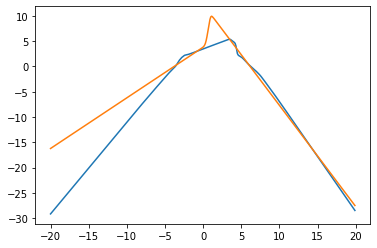

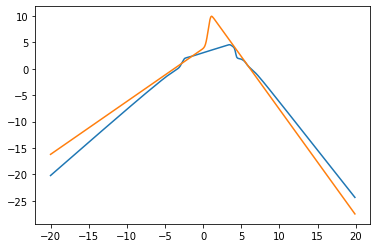

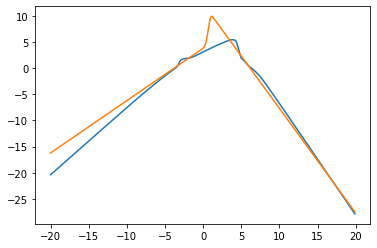

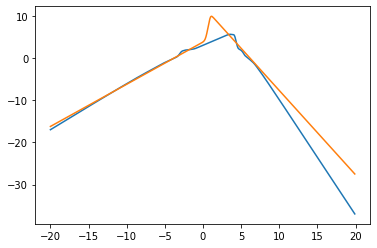

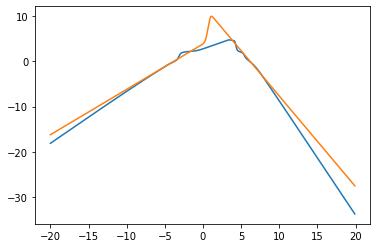

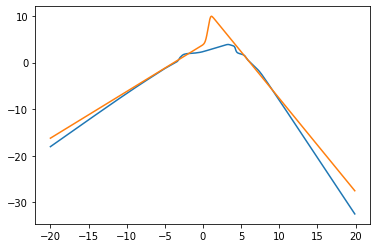

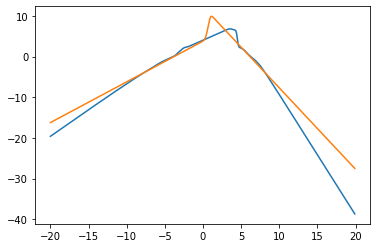

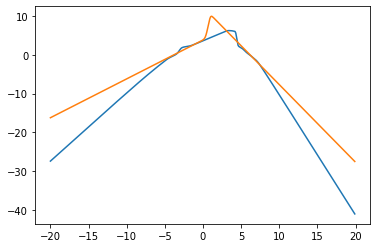

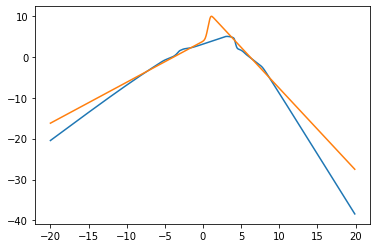

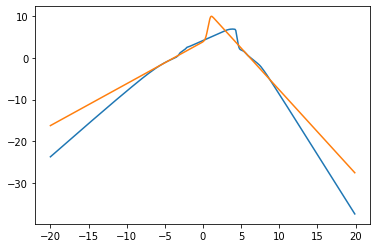

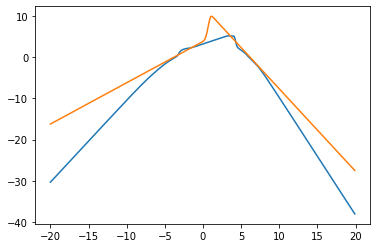

In [ ]:
for epoch in range(25):
    net.fit(x,y,epochs=4,verbose=0)
    plt.plot(rng,net.predict(rng))
    plt.plot(rng, np.log(f0.pdf(rng))- np.log(f1.pdf(rng)))
    plt.show()